У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data = pd.read_csv("train-2.csv")
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
data['date']= pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [4]:
data.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [5]:
print("\nІнформація про DataFrame:")
print(data.info())


Інформація про DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



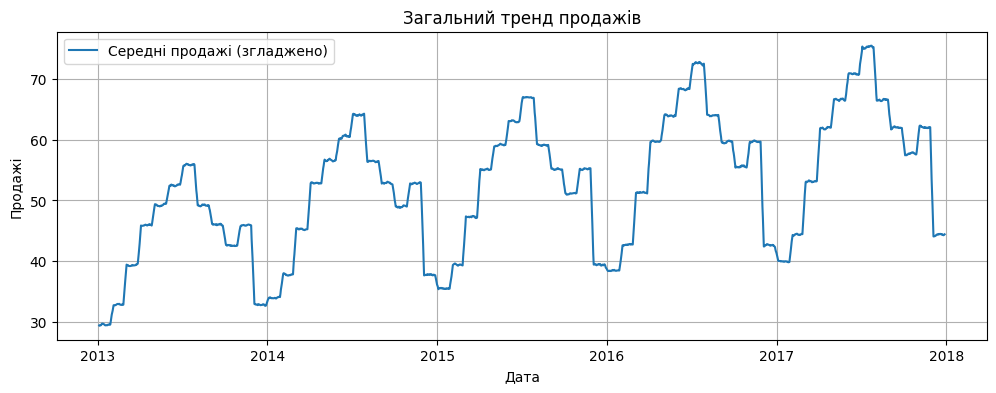

In [6]:
# усереднені продажі по всіх айтемах і магазинах
avg_sales = data.groupby("date")["sales"].mean().rolling(window=7, center=True).mean()

plt.figure(figsize=(12,4))
plt.plot(avg_sales.index, avg_sales.values, label="Середні продажі (згладжено)")
plt.title("Загальний тренд продажів")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.grid(True)
plt.legend()
plt.show()

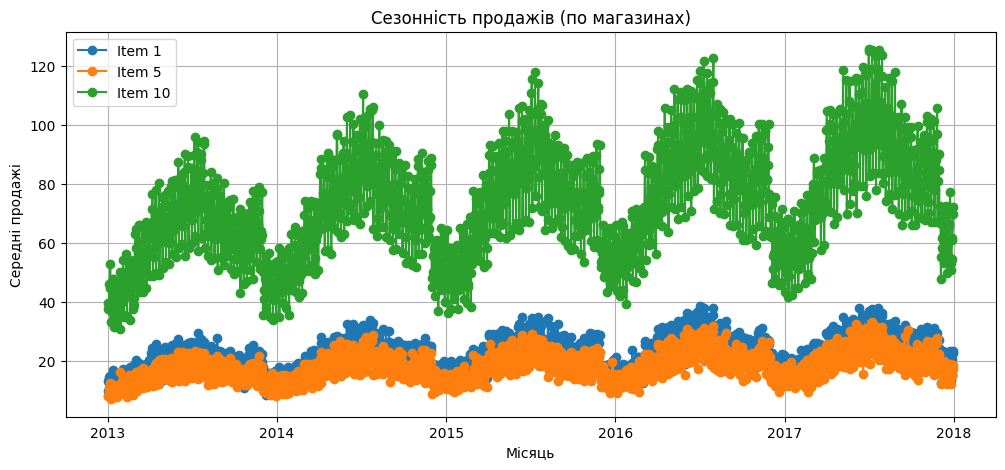

In [7]:
#Сезонність для вибраних айтемів (усереднено по магазинах)
sample_items = [1, 5, 10]
seasonality = data.groupby(["item", "date"])["sales"].mean().reset_index()

plt.figure(figsize=(12,5))
for item_id in sample_items:
    subset = seasonality[seasonality["item"] == item_id]
    plt.plot(subset["date"], subset["sales"], marker="o", label=f"Item {item_id}")
plt.title("Сезонність продажів (по магазинах)")
plt.xlabel("Місяць")
plt.ylabel("Середні продажі")
plt.legend()
plt.grid(True)
plt.show()


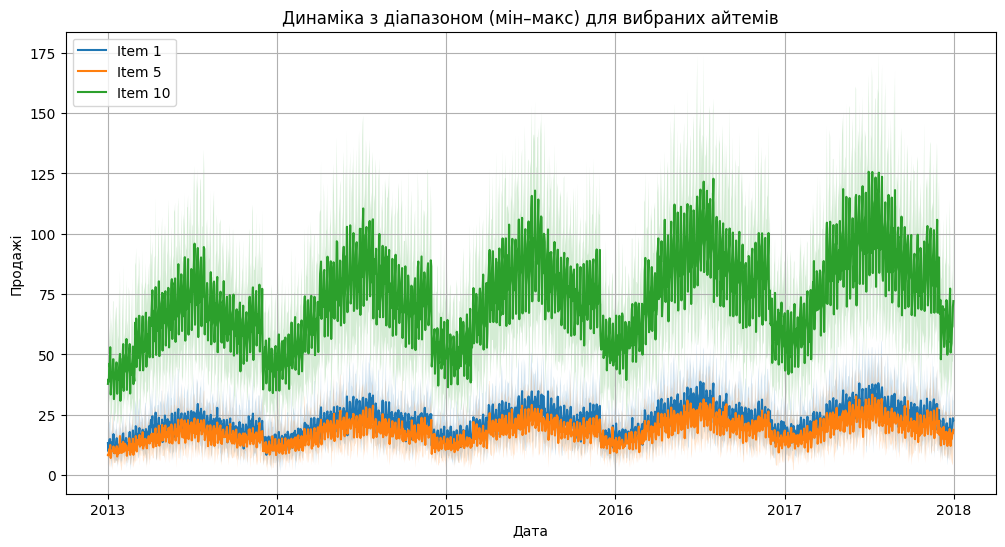

In [8]:
#Середнє + діапазон (мін–макс) для айтемів у різних магазинах
sample_items = [1, 5, 10]

plt.figure(figsize=(12,6))
for item_id in sample_items:
    data_item = data[data["item"] == item_id].groupby(["date", "store"])["sales"].mean().reset_index()
    agg = data_item.groupby("date")["sales"].agg(["mean", "min", "max"]).reset_index()

    x = mdates.date2num(agg["date"])
    y_mean = agg["mean"].astype(float).values
    y_min = agg["min"].astype(float).values
    y_max = agg["max"].astype(float).values

    plt.plot(agg["date"], y_mean, label=f"Item {item_id}")
    plt.fill_between(x, y_min, y_max, alpha=0.2)

plt.title("Динаміка з діапазоном (мін–макс) для вибраних айтемів")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.legend()
plt.grid(True)
plt.show()

Перший графік більш загальний, по ньому ми можемо бачити тенденцію до росту продажів з кожним роком загалом.
На двох інших ми бачимо порівняння певних айтомів, а саме 1, 5 та 10. Одразу кидається в очі. що айтом 10 більший за всіх по продажам, айтом 5 трохи менший за 1 в кількості продажів. Якщо дивитись на роки, то можна побачити, що 10 росте в кількості з кожним роком продаж, 5 та 1 айтоми відстають від нього.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [9]:
subset = data[(data["store"] == 1) & (data["item"] == 1)].copy()

In [10]:
subset.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


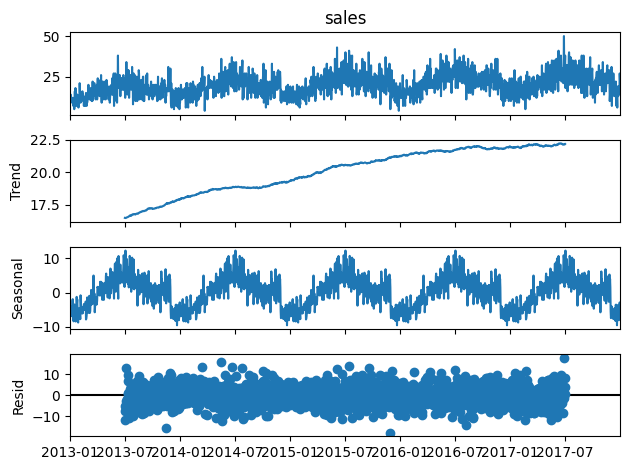

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Візуалізація адитивної декомпозиції для часового ряду
decomposition_plot_multi = seasonal_decompose(subset['sales'],
                                              model='additive',
                                              period = 365)
decomposition_plot_multi.plot()
plt.show()

Так, для більшого розуміння ситауції мені б було краще пропрацювати колонку з датою, бо важко орієнтуватись з такою датою на цих графіках.
Як висновок по графіку, можна сказати, що на продажі айтому 1 в магазині 1 має вплив сезонність, зроками потрохи ростуть продажі що має вплив на довгострокові продажі

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [12]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from darts import TimeSeries

# Завантаження даних в darts
series = TimeSeries.from_series(subset['sales'])

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

Text(0.5, 1.0, 'Train / Validation model')

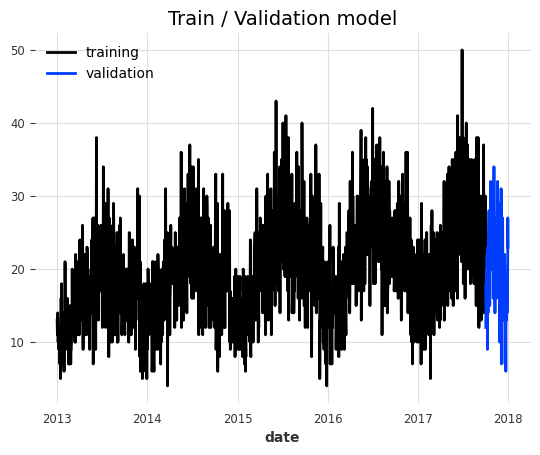

In [14]:
train, val = series.split_after(pd.Timestamp("2017-10-01"))
train.plot(label="training")
val.plot(label="validation")
plt.title("Train / Validation model", fontsize=14)

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [15]:
from darts.utils.statistics import plot_pacf, check_seasonality

<Figure size 1000x500 with 0 Axes>

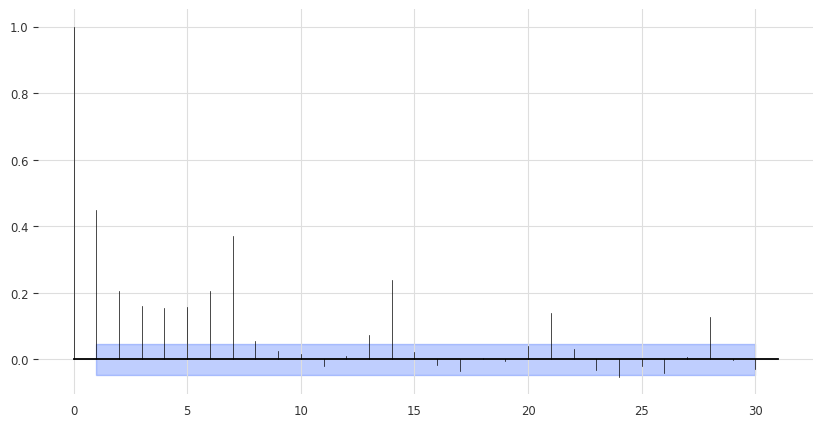

In [16]:
# побудова часткової автокореляційної функції
plt.figure(figsize=(10,5))
plot_pacf(series, max_lag=30)  # lags=30 можна змінити під довжину ряду
plt.show()

Лаги 1, 2 та 3 мають вплив, це видно з того що вони виходять за мені "синього". Також 7-й лаг має сильний вплив, як і перший, що може свідчити про сезонність.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [17]:
# Тижнева сезонність
is_seasonal, period = check_seasonality(train, m=7, max_lag=50)
print(f"Сезонність m=7: {is_seasonal}, період: {period}")

# Місячна сезонність
is_seasonal, period = check_seasonality(train, m=30, max_lag=50)
print(f"Сезонність m=30: {is_seasonal}, період: {period}")

# Річна сезонність
is_seasonal, period = check_seasonality(train, m=365, max_lag=400)
print(f"Сезонність m=365: {is_seasonal}, період: {period}")

Сезонність m=7: True, період: 7
Сезонність m=30: False, період: 30
Сезонність m=365: False, період: 365


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bd80a857ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.12/dist-packages/scipy.libs/libscipy_openblas-b75cc656.

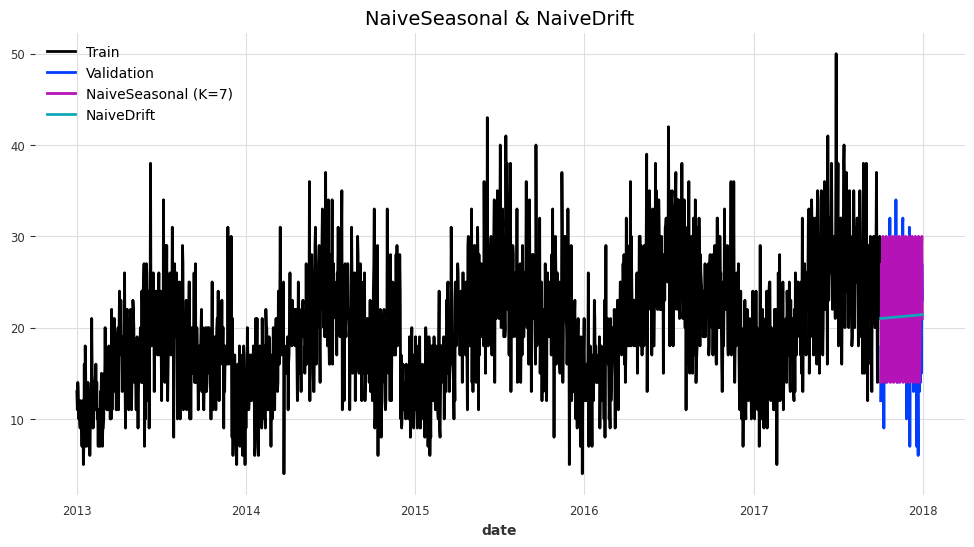

In [18]:
from darts.models import NaiveSeasonal, NaiveDrift

forecast_horizon = len(val)

# NaiveSeasonal
seasonal_model = NaiveSeasonal(K=7)  # обираю сезонність
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(forecast_horizon)

# NaiveDrift
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(forecast_horizon)

# Візуалізація
plt.figure(figsize=(12, 6))
train.plot(label="Train")
val.plot(label="Validation")
seasonal_forecast.plot(label="NaiveSeasonal (K=7)")
drift_forecast.plot(label="NaiveDrift")
plt.title("NaiveSeasonal & NaiveDrift", fontsize=14)
plt.legend()
plt.show()

Модель Naive Seasonal більш точна для цього ряду, оскільки дані мають виражену сезонність. Naive Drift не підходить, бо не враховує сезонних циклів.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [19]:
from darts.metrics import mape

mape_seasonal = mape(val, seasonal_forecast)
mape_drift = mape(val, drift_forecast)

print(f"MAPE NaiveSeasonal: {mape_seasonal:.2f}%")
print(f"MAPE NaiveDrift: {mape_drift:.2f}%")

MAPE NaiveSeasonal: 38.77%
MAPE NaiveDrift: 31.01%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [20]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import ExponentialSmoothing

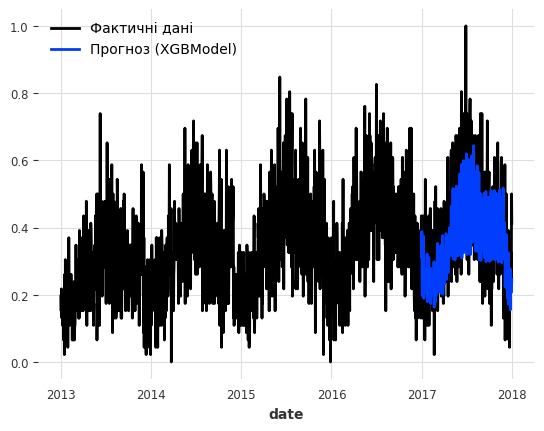

MAPE: 28.129800900899816
RMSE: 0.11541353621328523


In [21]:
# масштабування для стабілізації
scaler = Scaler()
series_scaled = scaler.fit_transform(series)

# додаткові ознаки по дати
year = datetime_attribute_timeseries(series_scaled, attribute="year", one_hot=False)
month = datetime_attribute_timeseries(series_scaled, attribute="month", one_hot=True)
day_of_week = datetime_attribute_timeseries(series_scaled, attribute="day_of_week", one_hot=True)

covariates = year.stack(month).stack(day_of_week)

#розбиття на трейн та вал
train, val = series_scaled.split_before(0.8)

#тренування XGBModel
model = XGBModel(
    lags=12,                 # беремо попередні 12 днів як лаги
    lags_past_covariates=1, # також враховуємо лаги від додаткових ознак
    output_chunk_length=1,   # прогноз на 1 крок уперед
    learning_rate=0.1
)

model.fit(train, past_covariates=covariates)

#Прогноз
forecast = model.predict(n=len(val), past_covariates=covariates)

#візуалізація
series_scaled.plot(label="Фактичні дані")
forecast.plot(label="Прогноз (XGBModel)")
plt.legend()
plt.show()

from darts.metrics import mape, rmse

print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))


Висновки не дуже при MAPE = 28, скоріш за все мало додано ознак, бо такий показник свідчить про високий % помилки.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

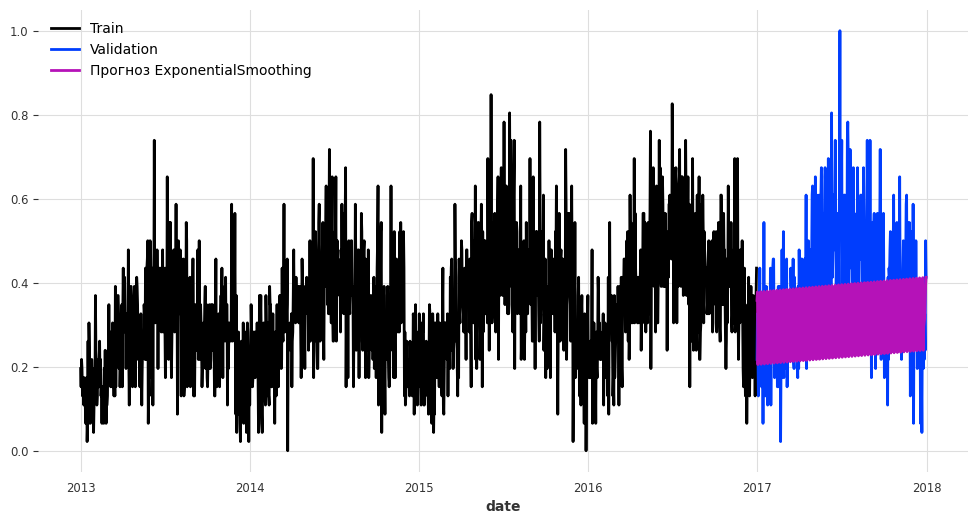

MAPE: 36.85807469574322
RMSE: 0.15716153198121996


In [22]:
model = ExponentialSmoothing()
model.fit(train)

#прогноз
forecast = model.predict(len(val))

# 3. Візуалізація
plt.figure(figsize=(12,6))
train.plot(label="Train")
val.plot(label="Validation")
forecast.plot(label="Прогноз ExponentialSmoothing")
plt.legend()
plt.show()

# -------------------------------
# 4. Метрики
print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))

Знову ж таки MAPE= 36, що свідчиить про високий % помилки. На графіку ми можемо бачити загальний тренд, але не бачимо на рожевому впливу сезонності або інших ознак.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [23]:
from darts.models import ARIMA, AutoARIMA

MAPE: 34.2486813466593
RMSE: 5.7450223462537515


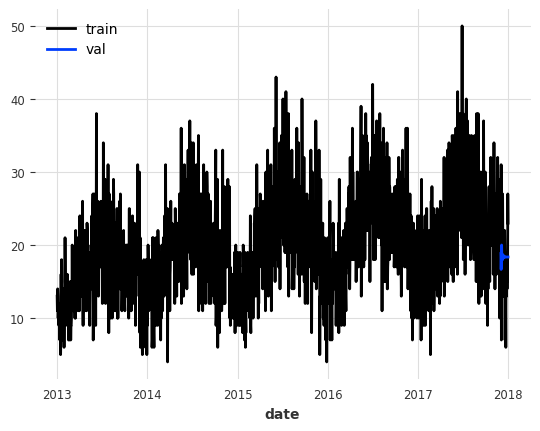

In [24]:
# Розділила набори
train, val = series[:-30], series[-30:]

# Створимо і натренуємо ARIMА
model = ARIMA(p=5, d=1, q=0)
model.fit(train)

forecast = model.predict(n=30)

print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))

# Візуалізація
series.plot(label='train')
forecast.plot(label='val')
plt.legend()
plt.show()

Знову ж таки MAPE= 34, що свідчиить про високий % помилки. На графіку ми можемо бачити загальний тренд, але не бачимо на рожевому впливу сезонності або інших ознак.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

MAPE: 46.36110124950708
RMSE: 6.68145106034829


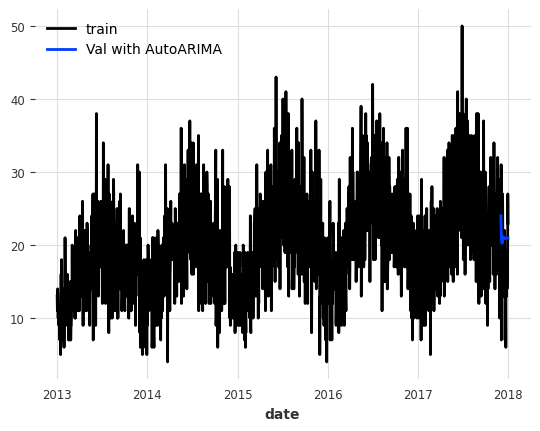

In [25]:
auto_model = AutoARIMA()
auto_model.fit(train)

forecast = auto_model.predict(n=30)

# Оцінка якості
print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))

# Візуалізація
series.plot(label='train')
forecast.plot(label='Val with AutoARIMA')
plt.legend()
plt.show()

На попередньоу графіку без AutoARIMA справи йшли краще ніж з нею. Для такого аналізу AutoARIMA не підходить, або ж треба більше додаткових ознак

14. Натренуйте модель Prophet та зробіть висновок про її якість.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptyamqhvu/aj5qlbu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptyamqhvu/86qo1dbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11017', 'data', 'file=/tmp/tmptyamqhvu/aj5qlbu9.json', 'init=/tmp/tmptyamqhvu/86qo1dbe.json', 'output', 'file=/tmp/tmptyamqhvu/prophet_modelo_4sej9d/prophet_model-20250925132112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


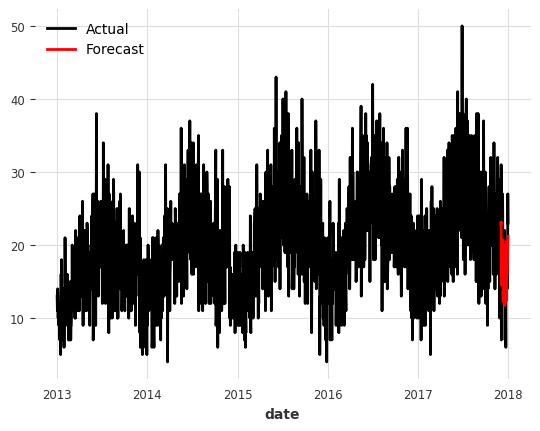

In [26]:
from darts.models import Prophet

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [27]:
print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))

MAPE: 27.903817707739645
RMSE: 4.6550991983762335


По результатам ця модель показала себе найкраще, можна побачити навіть трохи коливання трендів чи сезонності(червоне)

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

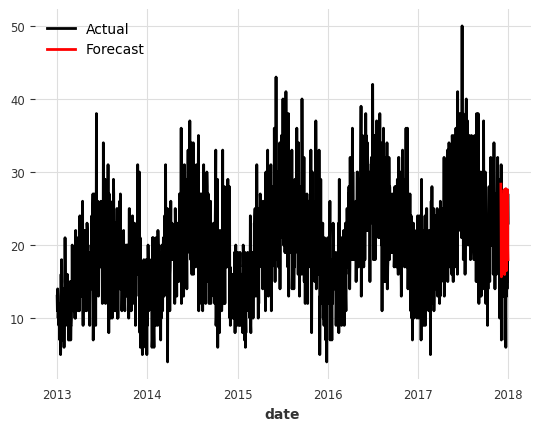

In [28]:
from darts.models import RNNModel

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train)

# Прогнозування
forecast = model.predict(len(val))

# Візуалізація результатів
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [29]:
# Оцінка якості
print("MAPE:", mape(val, forecast))
print("RMSE:", rmse(val, forecast))

MAPE: 59.76881309998392
RMSE: 8.816684096050766


RNN на наших даних не змогла добре навчитися через невеликий обсяг ряду та швидку змінність продажів. Модель відтворює загальні тренди, але робить великі помилки у прогнозі

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

historical forecasts:   0%|          | 0/12 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptyamqhvu/mfq6ev1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptyamqhvu/adrb6hdv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54008', 'data', 'file=/tmp/tmptyamqhvu/mfq6ev1b.json', 'init=/tmp/tmptyamqhvu/adrb6hdv.json', 'output', 'file=/tmp/tmptyamqhvu/prophet_modelu1pft_ai/prophet_model-20250925132712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
historical forecasts:   8%|▊         | 1/12 [00:00<00:05,  2.17it/s]INFO:prophet:D

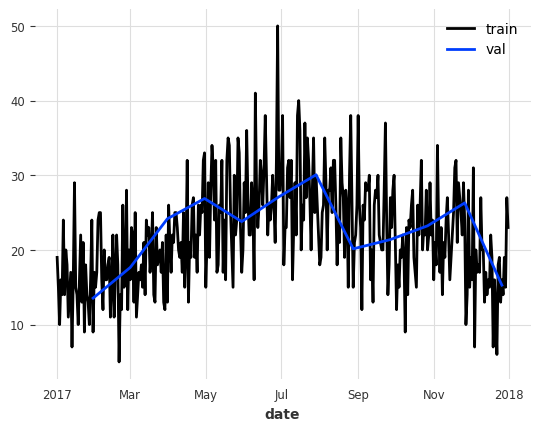

MAPE бектесту: 24.490479568804393
RMSE бектесту: 5.0555596038884785


In [30]:
# найкраща модель - Prophet
best_model = Prophet()

# Виконуємо бектест на останні 12 місяців
forecast_horizon = 30
backtest_series = series[-365:]

historical_forecasts = best_model.historical_forecasts(
    series,
    start=pd.Timestamp(series.time_index[-365]),
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,   # крок прогнозу = 1 місяць
    retrain=True,             # повторне навчання перед кожним прогнозом
    verbose=True
)

# Візуалізація
series[-365:].plot(label='train')
historical_forecasts.plot(label='val')
plt.legend()
plt.show()

# Оцінка точності бектесту
mape_value = mape(backtest_series, historical_forecasts)
rmse_value = rmse(backtest_series, historical_forecasts)
print("MAPE бектесту:", mape_value)
print("RMSE бектесту:", rmse_value)

дивлячись на показники MAPE, розумію, що це не дуже гарний та надійний показник, але краще ніж було в попередніх моделях

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

Я б прописала всі ознаки, які мають вплив (свята, певні події виходячи з регіону, сезонність, акції, військові дії, політичні події(це вже для реального життя)).
Обрала б як би я оцінювала та прогнозувала, окремо кожен айтем у конкретному магазині, або ж загалом айтом не зважаючи на магазин.
Обрала б XGBoost, бо для 500 айтемів це буде швидке тренування.
Тренувала б 500 моделей, модель яка буде працювати для 1-го айтома в 1-му магазині.


In [32]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace my_notebook.ipynb

[NbConvertApp] WARNING | pattern 'my_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
   

In [35]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --ClearMetadataPreprocessor.enabled=True --inplace notebook_name.ipynb

[NbConvertApp] WARNING | pattern 'notebook_name.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [36]:
!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --ClearMetadataPreprocessor.enabled=True --inplace "/content/drive/MyDrive/my_notebook.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/my_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_